# Model Evaluation Results Comparison

This notebook compares evaluation results across multiple models:
- Gemini 2.5 Flash Lite
- Qwen3-4B-Instruct-2507-base
- Qwen3-4B-Instruct-2507-ft-oncograph
- Qwen3-1.7B-ft-oncograph
- Gemini 2.0 Flash

Metrics compared:
- Syntactic validity (%) - queries passing custom syntax validation
- Execution success (%) - queries that execute without errors
- Output accuracy (%) - most important metric, queries that return the correct answer
- Average latency (ms) - average time taken to execute a query
- Token usage (input/output) - average number of tokens used in input/output


In [5]:
# Setup
import json
import os
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cycler

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Unified color palette for all charts
PALETTE = [
    "#4C78A8",  # blue
    "#F58518",  # orange
    "#54A24B",  # green
    "#E45756",  # red
    "#72B7B2",  # teal
    "#B279A2",  # purple
    "#FF9DA6",  # pink
]
plt.rcParams["axes.prop_cycle"] = cycler(color=PALETTE)

# Set up paths
NOTEBOOK_DIR = Path(os.getcwd())
RESULTS_DIR = NOTEBOOK_DIR.parent / "evaluation" / "results"

print(f"Results directory: {RESULTS_DIR}")
print(f"Results directory exists: {RESULTS_DIR.exists()}")

Results directory: c:\Users\ishui\Desktop\OncoGraph\OncoGraph Agent\finetuning\evaluation\results
Results directory exists: True


In [6]:
# Discover and load all evaluation result JSON files
def load_evaluation_results(results_dir: Path) -> dict[str, dict[str, Any]]:
    """Load all evaluation result JSON files from the results directory."""
    all_results = {}

    # Find all *_evaluation_results.json files
    result_files = list(results_dir.glob("*_evaluation_results.json"))

    print(f"Found {len(result_files)} evaluation result files:")

    for result_file in sorted(result_files):
        # Extract model name from filename (e.g., "gemini-2.5-flash-lite_evaluation_results.json" -> "gemini-2.5-flash-lite")
        model_name = result_file.stem.replace("_evaluation_results", "")

        print(f"  Loading: {model_name}")

        with result_file.open("r", encoding="utf-8") as f:
            data = json.load(f)

            # Extract metrics for this model
            if "models" in data and model_name in data["models"]:
                all_results[model_name] = data["models"][model_name]["metrics"]
                all_results[model_name]["timestamp"] = data.get("timestamp", "")
                all_results[model_name]["test_set_size"] = data.get("test_set_size", 0)
            else:
                print(f"    Warning: Could not find metrics for {model_name}")

    return all_results


# Load all results
evaluation_results = load_evaluation_results(RESULTS_DIR)

print(f"\nLoaded {len(evaluation_results)} model evaluation results")
print(f"Models: {list(evaluation_results.keys())}")

Found 5 evaluation result files:
  Loading: gemini-2.0-flash
  Loading: gemini-2.5-flash-lite
  Loading: qwen3-1.7b-trained
  Loading: qwen3-4b-it-2507-base
  Loading: qwen3-4b-it-2507-trained

Loaded 5 model evaluation results
Models: ['gemini-2.0-flash', 'gemini-2.5-flash-lite', 'qwen3-1.7b-trained', 'qwen3-4b-it-2507-base', 'qwen3-4b-it-2507-trained']


In [7]:
# Create comparison DataFrame
def create_comparison_dataframe(results: dict[str, dict[str, Any]]) -> pd.DataFrame:
    """Create a DataFrame for easy comparison of metrics across models."""

    rows = []

    for model_name, metrics in results.items():
        # Map raw model names to cleaner display names for charts
        raw_model_name = model_name
        if model_name == "qwen3-4b-it-2507-trained":
            display_model_name = "qwen3-4b-ft-oncograph"
        elif model_name == "qwen3-4b-it-2507-base":
            display_model_name = "qwen3-4b-base"
        elif model_name == "qwen3-1.7b-trained":
            display_model_name = "qwen3-1.7b-ft-oncograph"
        else:
            display_model_name = model_name

        row = {
            "Raw Model": raw_model_name,
            "Model": display_model_name,
            "Syntactic Validity (%)": metrics.get("syntactic_validity_pct", 0),
            "Execution Success (%)": metrics.get("execution_success_pct", 0),
            "Output Accuracy (%)": metrics.get("output_accuracy_pct", 0),
            "Avg Latency (ms)": metrics.get("avg_latency_ms", 0),
            "Avg Input Tokens": metrics.get("avg_input_tokens", 0),
            "Avg Output Tokens": metrics.get("avg_output_tokens", 0),
            "Total Input Tokens": metrics.get("total_input_tokens", 0),
            "Total Output Tokens": metrics.get("total_output_tokens", 0),
            "Test Set Size": metrics.get("test_set_size", metrics.get("total", 0)),
            "Timestamp": metrics.get("timestamp", ""),
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    # Sort by output accuracy (descending)
    df = df.sort_values("Output Accuracy (%)", ascending=False)

    return df


comparison_df = create_comparison_dataframe(evaluation_results)

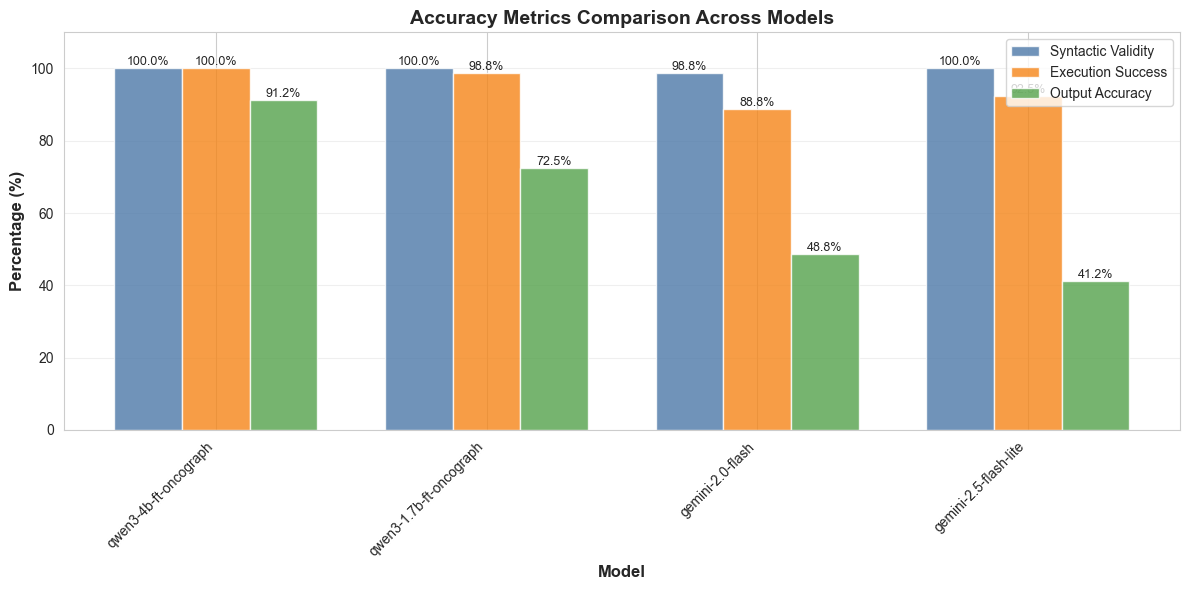

In [8]:
# Filter out base models (keep only fine-tuned or flash models)
filtered_df = comparison_df[comparison_df["Raw Model"] != "qwen3-4b-it-2507-base"]

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
x = range(len(filtered_df))
width = 0.25

syntactic = filtered_df["Syntactic Validity (%)"]
execution = filtered_df["Execution Success (%)"]
output_acc = filtered_df["Output Accuracy (%)"]

# Create bars
bars1 = ax.bar([i - width for i in x], syntactic, width, label="Syntactic Validity", alpha=0.8, color=PALETTE[0])
bars2 = ax.bar(x, execution, width, label="Execution Success", alpha=0.8, color=PALETTE[1])
bars3 = ax.bar([i + width for i in x], output_acc, width, label="Output Accuracy", alpha=0.8, color=PALETTE[2])

# Customize
ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Percentage (%)", fontsize=12, fontweight="bold")
ax.set_title("Accuracy Metrics Comparison Across Models", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(filtered_df["Model"], rotation=45, ha="right")
ax.set_ylim(0, 110)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()

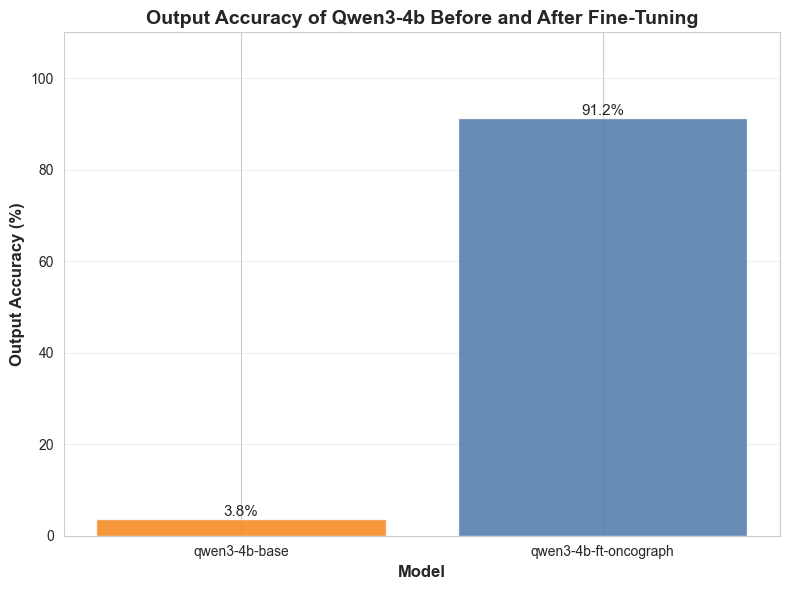

In [9]:
# Plot a side-by-side bar chart for Output Accuracy of qwen3-4b before and after fine-tuning

# Select qwen3-4b rows (before and after finetuning)
qwen_models = comparison_df[
    (comparison_df["Raw Model"].isin(["qwen3-4b-it-2507-base", "qwen3-4b-it-2507-trained"]))
]

labels = [
    "qwen3-4b-base",
    "qwen3-4b-ft-oncograph"
]
accuracies = [
    float(qwen_models[qwen_models["Raw Model"] == "qwen3-4b-it-2507-base"]["Output Accuracy (%)"].values[0]),
    float(qwen_models[qwen_models["Raw Model"] == "qwen3-4b-it-2507-trained"]["Output Accuracy (%)"].values[0])
]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, accuracies, color=[PALETTE[1], PALETTE[0]], alpha=0.85)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Output Accuracy (%)", fontsize=12, fontweight="bold")
ax.set_title("Output Accuracy of Qwen3-4b Before and After Fine-Tuning", fontsize=14, fontweight="bold")
ax.set_ylim(0, 110)
ax.grid(axis="y", alpha=0.3)

# Value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
    )

plt.tight_layout()
plt.show()


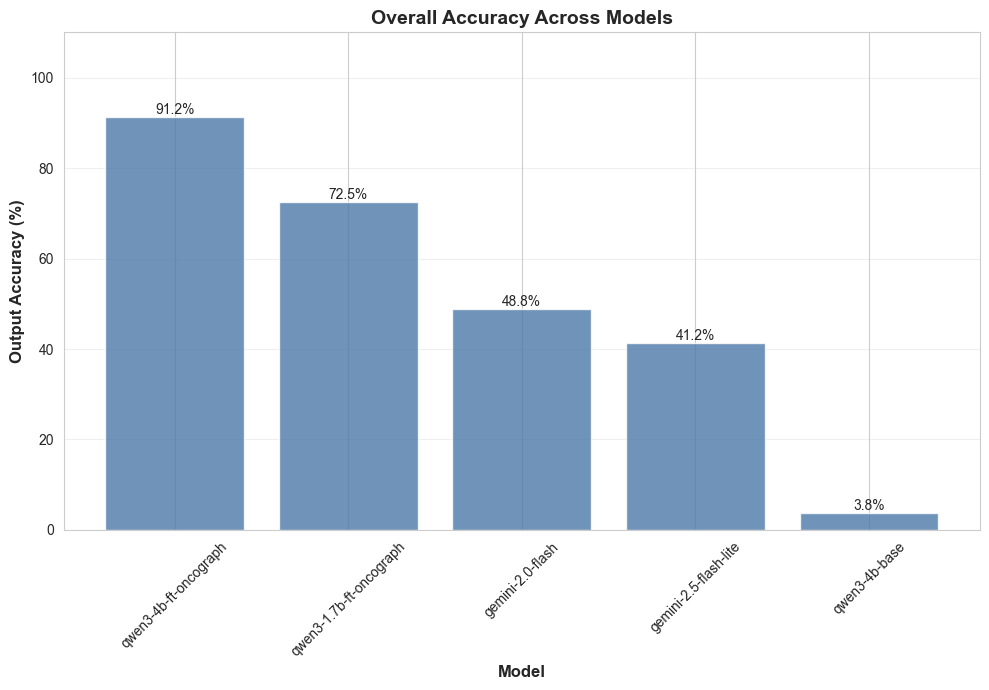

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(
    comparison_df["Model"],
    comparison_df["Output Accuracy (%)"],
    color=PALETTE[0],
    alpha=0.8,
)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Output Accuracy (%)", fontsize=12, fontweight="bold")
ax.set_title("Overall Accuracy Across Models", fontsize=14, fontweight="bold")
ax.set_ylim(0, 110)
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

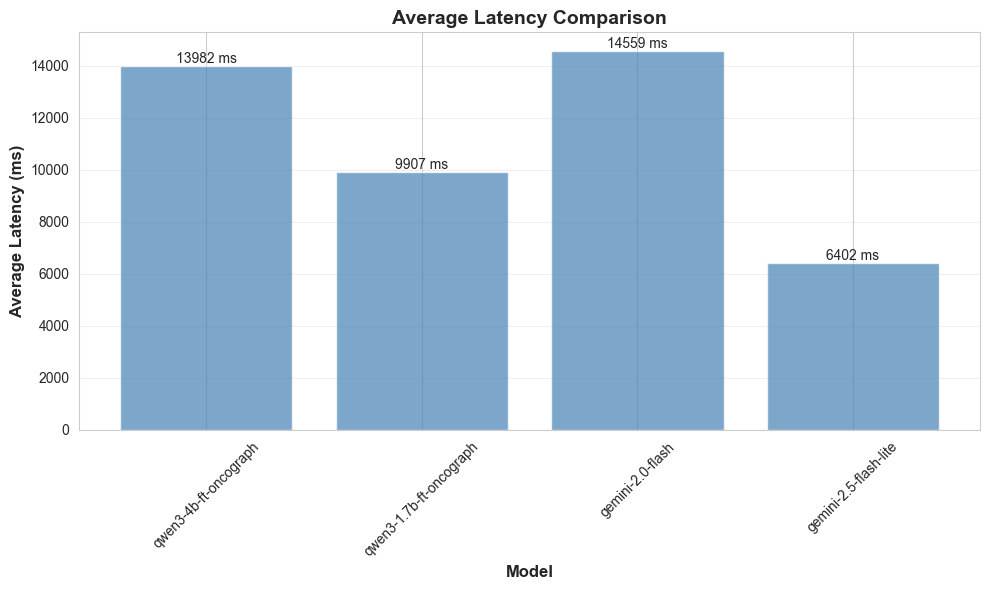

In [11]:
# Visualization 2: Performance Metrics (Latency)

latency_df = comparison_df[comparison_df["Raw Model"] != "qwen3-4b-it-2507-base"]

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    latency_df["Model"],
    latency_df["Avg Latency (ms)"],
    alpha=0.7,
    color="steelblue",
)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Average Latency (ms)", fontsize=12, fontweight="bold")
ax.set_title("Average Latency Comparison", fontsize=14, fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3, axis="y")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.0f} ms",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

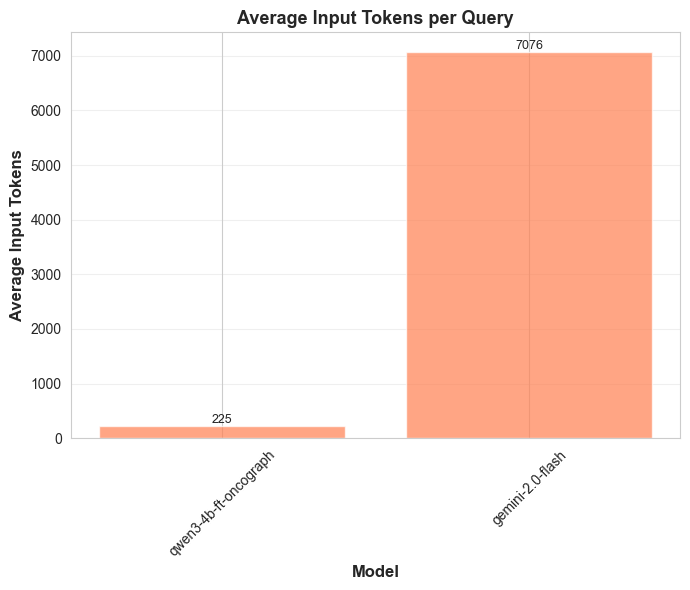

In [12]:
tokens_df = comparison_df[~comparison_df["Raw Model"].isin(["qwen3-4b-it-2507-base", "qwen3-1.7b-trained", "gemini-2.5-flash-lite"])]

fig, ax1 = plt.subplots(figsize=(7, 6))

# Input tokens
bars1 = ax1.bar(
    tokens_df["Model"],
    tokens_df["Avg Input Tokens"],
    alpha=0.7,
    color="coral",
)
ax1.set_xlabel("Model", fontsize=12, fontweight="bold")
ax1.set_ylabel("Average Input Tokens", fontsize=12, fontweight="bold")
ax1.set_title("Average Input Tokens per Query", fontsize=13, fontweight="bold")
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, alpha=0.3, axis="y")

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

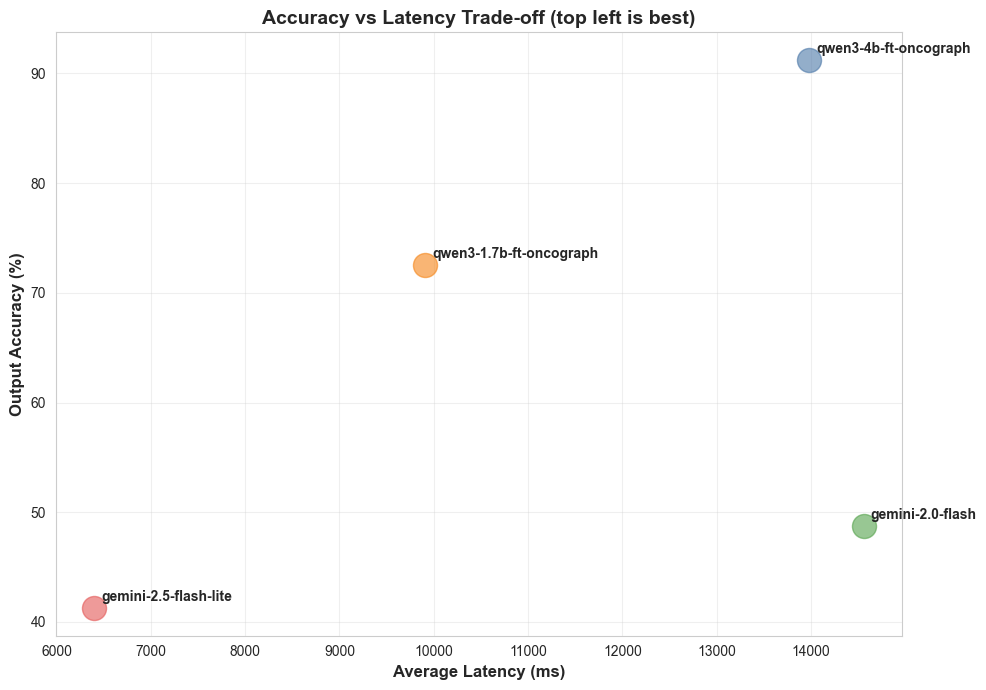

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

# Exclude Qwen base model from trade-off chart
tradeoff_df = comparison_df[comparison_df["Raw Model"] != "qwen3-4b-it-2507-base"]

# Scatter plot
for _, row in tradeoff_df.iterrows():
    ax.scatter(
        row["Avg Latency (ms)"],
        row["Output Accuracy (%)"],
        s=300,
        alpha=0.6,
        label=row["Model"],
    )
    ax.annotate(
        row["Model"],
        (row["Avg Latency (ms)"], row["Output Accuracy (%)"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Average Latency (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Output Accuracy (%)", fontsize=12, fontweight="bold")
ax.set_title("Accuracy vs Latency Trade-off (top left is best)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("=" * 80)
print("EVALUATION RESULTS SUMMARY")
print("=" * 80)

for _, row in comparison_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Syntactic Validity: {row['Syntactic Validity (%)']:.2f}%")
    print(f"  Execution Success: {row['Execution Success (%)']:.2f}%")
    print(f"  Output Accuracy: {row['Output Accuracy (%)']:.2f}%")
    print(f"  Avg Latency: {row['Avg Latency (ms)']:.2f} ms")
    print(f"  Avg Input Tokens: {row['Avg Input Tokens']:.0f}")
    print(f"  Avg Output Tokens: {row['Avg Output Tokens']:.0f}")
    print(f"  Test Set Size: {row['Test Set Size']:.0f}")

print("\n" + "=" * 80)

# Best performers
print("\nBEST PERFORMERS:")
print(
    f"  Highest Output Accuracy: {comparison_df.loc[comparison_df['Output Accuracy (%)'].idxmax(), 'Model']} ({comparison_df['Output Accuracy (%)'].max():.2f}%)"
)
print(
    f"  Fastest: {comparison_df.loc[comparison_df['Avg Latency (ms)'].idxmin(), 'Model']} ({comparison_df['Avg Latency (ms)'].min():.2f} ms)"
)
print(
    f"  Most Syntactically Valid: {comparison_df.loc[comparison_df['Syntactic Validity (%)'].idxmax(), 'Model']} ({comparison_df['Syntactic Validity (%)'].max():.2f}%)"
)
print(
    f"  Best Execution Success: {comparison_df.loc[comparison_df['Execution Success (%)'].idxmax(), 'Model']} ({comparison_df['Execution Success (%)'].max():.2f}%)"
)

EVALUATION RESULTS SUMMARY

qwen3-4b-ft-oncograph:
  Syntactic Validity: 100.00%
  Execution Success: 100.00%
  Output Accuracy: 91.25%
  Avg Latency: 13982.06 ms
  Avg Input Tokens: 225
  Avg Output Tokens: 229
  Test Set Size: 80

qwen3-1.7b-ft-oncograph:
  Syntactic Validity: 100.00%
  Execution Success: 98.75%
  Output Accuracy: 72.50%
  Avg Latency: 9906.86 ms
  Avg Input Tokens: 225
  Avg Output Tokens: 223
  Test Set Size: 80

gemini-2.0-flash:
  Syntactic Validity: 98.75%
  Execution Success: 88.75%
  Output Accuracy: 48.75%
  Avg Latency: 14558.57 ms
  Avg Input Tokens: 7076
  Avg Output Tokens: 233
  Test Set Size: 80

gemini-2.5-flash-lite:
  Syntactic Validity: 100.00%
  Execution Success: 92.50%
  Output Accuracy: 41.25%
  Avg Latency: 6401.69 ms
  Avg Input Tokens: 7165
  Avg Output Tokens: 267
  Test Set Size: 80

qwen3-4b-base:
  Syntactic Validity: 88.75%
  Execution Success: 53.75%
  Output Accuracy: 3.75%
  Avg Latency: 135.36 ms
  Avg Input Tokens: 225
  Avg Output 

## Detailed Per-Question Analysis (Optional)

To analyze per-question results, load the summary CSV files:


In [15]:
# Load detailed per-question results (optional)
def load_summary_csvs(results_dir: Path) -> dict[str, pd.DataFrame]:
    """Load all summary CSV files."""
    csv_files = list(results_dir.glob("*_summary.csv"))
    summaries = {}

    for csv_file in sorted(csv_files):
        model_name = csv_file.stem.replace("_summary", "")
        df = pd.read_csv(csv_file)

        # Convert checkmarks to boolean
        if "syntactic_valid" in df.columns:
            df["syntactic_valid"] = df["syntactic_valid"].apply(lambda x: x == "✓")
        if "execution_success" in df.columns:
            df["execution_success"] = df["execution_success"].apply(lambda x: x == "✓")
        if "result_match" in df.columns:
            df["result_match"] = df["result_match"].apply(lambda x: x == "✓")

        summaries[model_name] = df
        print(f"Loaded {len(df)} records for {model_name}")

    return summaries


# Uncomment to load detailed results
# detailed_results = load_summary_csvs(RESULTS_DIR)
# print(f"\nLoaded {len(detailed_results)} detailed result sets")

In [16]:
# Example: Compare per-question results across models (optional)
# Uncomment to run

# if 'detailed_results' in globals() and detailed_results:
#     # Find questions where models differ
#     all_ids = set()
#     for df in detailed_results.values():
#         all_ids.update(df['id'])
#
#     comparison_detailed = []
#     for qid in sorted(all_ids):
#         row = {'id': qid}
#         for model_name, df in detailed_results.items():
#             model_row = df[df['id'] == qid]
#             if not model_row.empty:
#                 row[model_name] = '✓' if model_row.iloc[0]['result_match'] else '✗'
#             else:
#                 row[model_name] = 'N/A'
#         comparison_detailed.append(row)
#
#     comparison_detailed_df = pd.DataFrame(comparison_detailed)
#     display(comparison_detailed_df.head(20))